##### Welcome to this Data Science home assignment !


This is an opportunity for you to show off your BIG data skills and thought processes as a Data Scientist.

In this notebook, you are given a (relatively small) 1M rows dataset and is expected to **provide insights in relation to inauthentic rows (segments) or inauthentic users**.

Unlike human interaction with the touch screen which is charectarized by high variance and dispersion. Inauthentic patterns (e.g. scripted or automated) tends to be repetitive and have high peak to noise ratio.  
We hypothesize that patterns that are repetitive and/or have high peak to noise ratio are more likley to be inauthentic.

- Suggest and implement a big data approach to model the data and evaluate **the hypothesis above**. 

- Draw insights/conclusions/learnings and visualize the data to support your findings.

- Make sure to clearly describe: What are major learnings and conclusions can you share about inauthentic data segments (rows) or users? Is your implementation presicion or recall oriented? What would you explore further if you had more time?

- Consider both the efficiency and effectiveness of your approach. make sure to document your code and explain your thought process and decisions you made along the way.

Good luck!

In [0]:
import seaborn as sns
import numpy as np 
import pandas as pd
import pyspark.sql.functions as F

In [0]:
# read a delta table as a spark dataframe
df = spark.read.table('keep.cr2r39guebc0_ds_home_assignmnet_nov_2023')
df.cache()
f'{df.count():,d} rows loaded'

'1,000,000 rows loaded'

In [0]:
df.printSchema()

root
 |-- seg_id: string (nullable = true)
 |-- app_token: string (nullable = true)
 |-- platform: byte (nullable = true)
 |-- mode: byte (nullable = true)
 |-- prompt: byte (nullable = true)
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- additional_id: string (nullable = true)
 |-- seg_count: integer (nullable = true)
 |-- seg_name: string (nullable = true)
 |-- screen_width: short (nullable = true)
 |-- screen_height: short (nullable = true)
 |-- app_width: short (nullable = true)
 |-- app_height: short (nullable = true)
 |-- key_values: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- resolution_android: struct (nullable = true)
 |    |-- xdpi: double (nullable = true)
 |    |-- ydpi: double (nullable = true)
 |-- seq_motion: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- seq_acc: arra

In [0]:
print(f'num unique rows: {df.select("seg_id").distinct().count():,d}')
print(f'num unique users: {df.select("user_id").distinct().count():,d}')
print(f'num unique session_id: {df.select("session_id", "user_id", "seg_id").distinct().count():,d}')

num unique rows: 1,000,000
num unique users: 583,823
num unique session_id: 1,000,000


In [0]:
df.groupby('seg_name').count().display()

seg_name,count
LOGIN,5874
TUTORIAL,2495
REPLAY,4450
SPECTATE,5543
BATTLE,330148
CHEST,138139
MENU,513351


In [0]:
# schema
df.printSchema()

root
 |-- seg_id: string (nullable = true)
 |-- app_token: string (nullable = true)
 |-- platform: byte (nullable = true)
 |-- mode: byte (nullable = true)
 |-- prompt: byte (nullable = true)
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- additional_id: string (nullable = true)
 |-- seg_count: integer (nullable = true)
 |-- seg_name: string (nullable = true)
 |-- screen_width: short (nullable = true)
 |-- screen_height: short (nullable = true)
 |-- app_width: short (nullable = true)
 |-- app_height: short (nullable = true)
 |-- key_values: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- resolution_android: struct (nullable = true)
 |    |-- xdpi: double (nullable = true)
 |    |-- ydpi: double (nullable = true)
 |-- seq_motion: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- seq_acc: arra

In [0]:
df.groupBy("seg_name").agg(F.countDistinct("user_id").alias("number_of_users")).toPandas().sort_values(by = ["number_of_users"], ascending = False)


,seg_name,number_of_users
6,MENU,435450
4,BATTLE,308334
5,CHEST,117336
0,LOGIN,5459
3,SPECTATE,5388
2,REPLAY,4284
1,TUTORIAL,2465


##### Some useful info on the data at hand

- columns with sensor data all start with the prefix 'seq_' (since this data is sequencial in nature). this data, in each row, describes what the user does and how s/he interacts with the mobile device and game at a given timeframe.
- see below for **details on seq_motion**, which holds all the interactions (sampled) of a player with the screen.

In [0]:
from enum import IntEnum

"""
a seq_motion row will consist of 1 or more touch events (its a list of lists (ArrayType(ArrayType(DoubleType())))).
each single event is a list of values. you can use the variables below to access each property.
"""

# event_property to index
class MotionIndices(IntEnum):
    TS = 0
    DOWNTIME = 1
    TYPE = 2
    X = 3
    Y = 4
    SIZE = 5
    PRESSURE = 6
    ORIENTATION = 7
    POINTER_ID = 8

# index of timestamp for each event
MOTION_IDX_TS = MotionIndices.TS.value 

# index of timestamp of associated previous event (e.g. a sequence of touch events all part of the same gesture (like swipe for example) will all have the same value of the first event of the gesture)
MOTION_IDX_DOWNTIME = MotionIndices.DOWNTIME.value

# index of type for each event
MOTION_IDX_TYPE = MotionIndices.TYPE.value

# index of x value for each event
MOTION_IDX_X = MotionIndices.X.value

# index of y value for each event
MOTION_IDX_Y = MotionIndices.Y.value

#size, presuure, orientation - not supported by all os 

# index of size value for each event
MOTION_IDX_SIZE = MotionIndices.SIZE.value

# index of pressure value for each event
MOTION_IDX_PRESSURE = MotionIndices.PRESSURE.value

# index of orientation value for each event (this is the direction of the touch event if available)
MOTION_IDX_ORIENTATION = MotionIndices.ORIENTATION.value

# index of the finger used for each event, rising value for each additional finger interacting with the screen (at the same time)
MOTION_IDX_POINTER_ID = MotionIndices.POINTER_ID.value


# motion_type value to type. any event could be of type up/down/move
class CodeMotion(IntEnum):
    MOTION_DOWN = 1
    MOTION_POINTER_DOWN = 2
    MOTION_MOVE = 3
    MOTION_POINTER_UP = 4
    MOTION_UP = 5

# you can use these definition the decode motion event type to its meaning
# pointer is any additional finger interacting with the screen (at the same time)
CODE_MOTION_DOWN = CodeMotion.MOTION_DOWN.value
CODE_MOTION_POINTER_DOWN = CodeMotion.MOTION_POINTER_DOWN.value 
CODE_MOTION_MOVE = CodeMotion.MOTION_MOVE.value
CODE_MOTION_POINTER_UP = CodeMotion.MOTION_POINTER_UP.value
CODE_MOTION_UP = CodeMotion.MOTION_UP.value

In [0]:
df = df.withColumn("seq_motion_length", F.size(F.col("seq_motion")))
seq_motion_lengths_df = df.select(F.col("seq_motion_length"), F.col("seg_name")).toPandas()

In [0]:
np.max(seq_motion_lengths_df["seq_motion_length"]), np.min(seq_motion_lengths_df["seq_motion_length"])

(2000, 1)

<AxesSubplot:xlabel='seq_motion_length', ylabel='Count'>

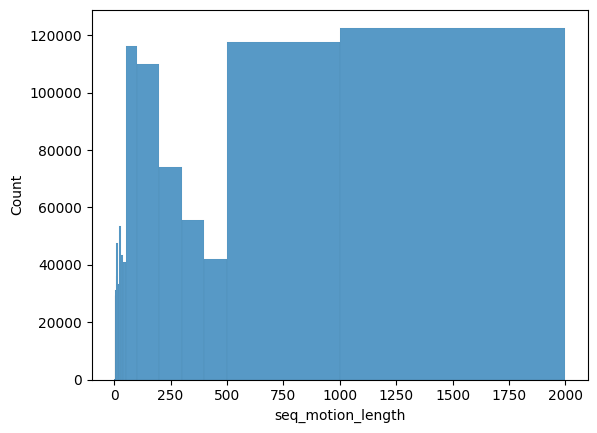

In [0]:
sns.histplot(data=seq_motion_lengths_df, x="seq_motion_length", bins = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000])


<AxesSubplot:xlabel='seq_motion_length', ylabel='Count'>

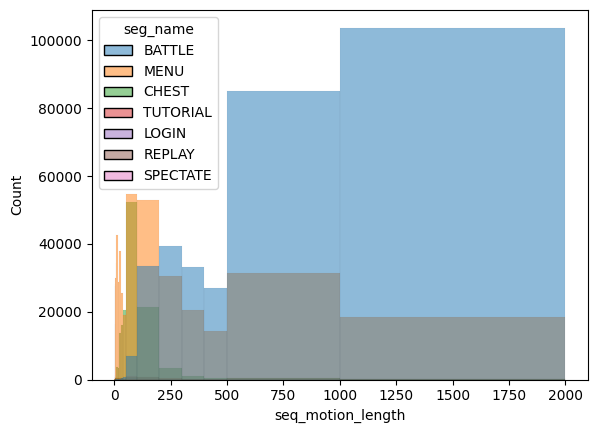

In [0]:
sns.histplot(data=seq_motion_lengths_df, x="seq_motion_length", hue = "seg_name", bins = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000])


<AxesSubplot:xlabel='seq_motion_length', ylabel='Count'>

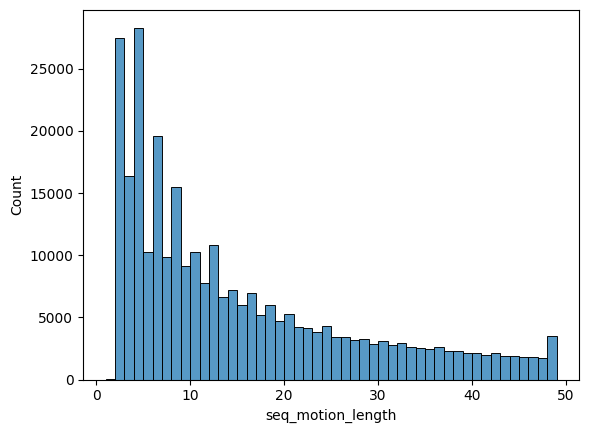

In [0]:
sns.histplot(data=seq_motion_lengths_df[seq_motion_lengths_df["seg_name"] == "MENU"], x="seq_motion_length", bins = range(1, 50))


In [0]:
rows = df.take(10)

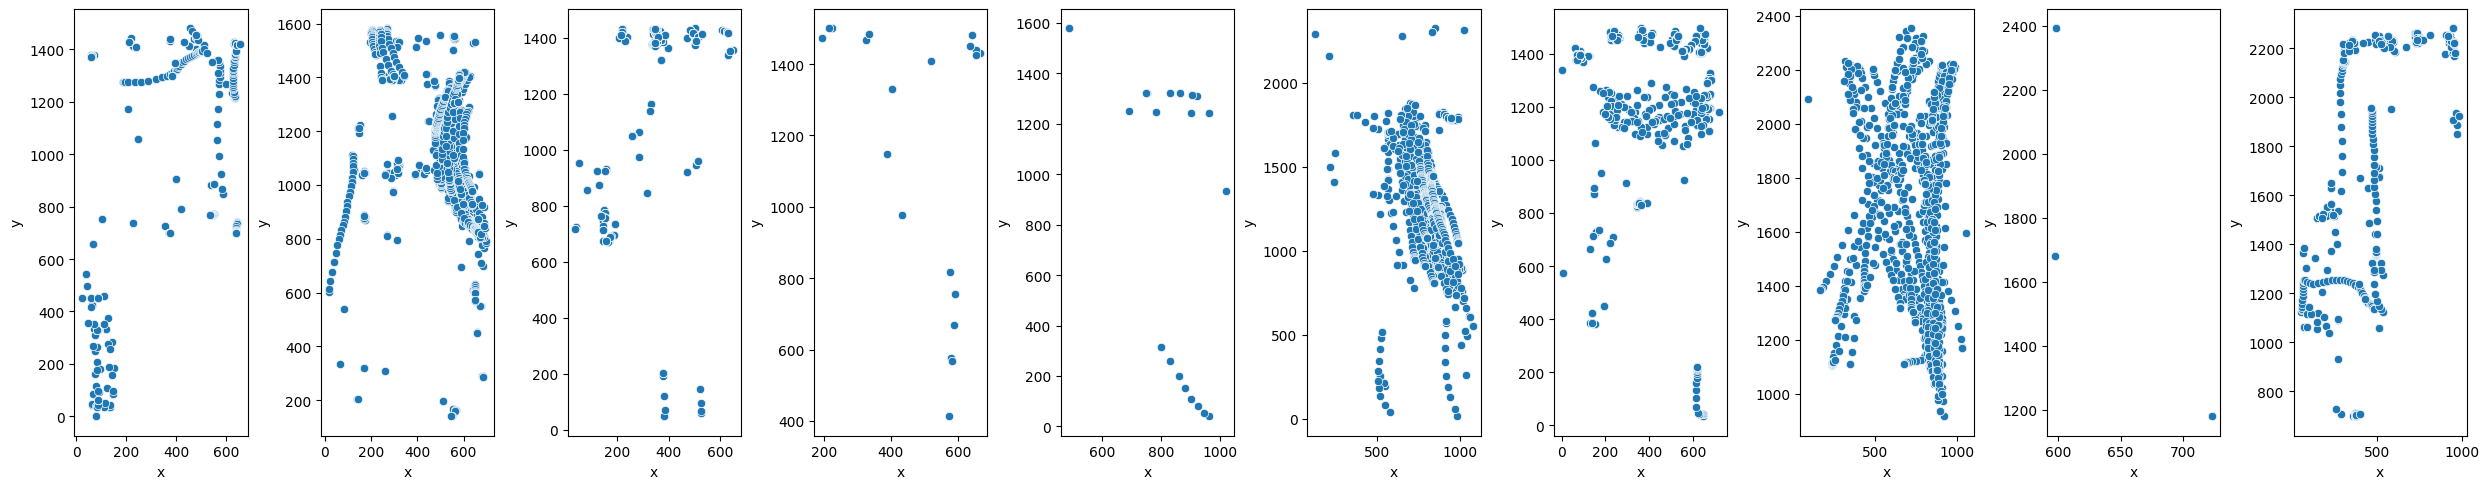

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_xy(rows, x_col, y_col):
    
    f, axes = plt.subplots(1, len(rows), figsize = (25, 5))

    for (i ,row) in enumerate(rows):

        seq_motions = row['seq_motion']
        xs = [seq_motion[x_col] for seq_motion in  seq_motions]
        ys = [seq_motion[y_col] for seq_motion in  seq_motions]
        
        xy_df = pd.DataFrame(zip(xs, ys), columns = ["x", "y"])
        sns.scatterplot(data=xy_df, x="x", y="y", ax = axes[i])

     
    f.tight_layout(h_pad=0.3, w_pad=0.3)
    

plot_xy(rows, MOTION_IDX_X, MOTION_IDX_Y)

In [0]:
# print out a few touch events

seq_motion = rows[0]['seq_motion']
touch_event = seq_motion[0]
event_timestamp = touch_event[MOTION_IDX_TS]
event_type = touch_event[MOTION_IDX_TYPE]
event_x = touch_event[MOTION_IDX_X]
event_y = touch_event[MOTION_IDX_Y]
size = touch_event[MOTION_IDX_SIZE]
touch_event, event_type, len(seq_motion)
motion_pressure = touch_event[MOTION_IDX_PRESSURE]
motion_orientation = touch_event[MOTION_IDX_ORIENTATION]
motion_pointer = touch_event[MOTION_IDX_POINTER_ID]


event_timestamp, event_type, event_x, event_y, size, motion_pressure, motion_orientation, motion_pointer

(0.0, 3.0, 550.0, 771.0, 0.019607844, 1.0, 0.0, 0.0)

In [0]:
def calc_mean(seq_motion, i):
    arr = np.array([r[i] for r in seq_motion if r[i] is not None])
    return np.mean(arr).item()

def calc_std(seq_motion, i):
    arr = np.array([r[i] for r in seq_motion if r[i] is not None])
    return np.std(arr).item()

In [0]:
from pyspark.sql.types import FloatType, ArrayType

mean_udf = udf(calc_mean, FloatType())
std_udf = udf(calc_std, FloatType())

cols_woth_index = [
    ("touch_ts", MOTION_IDX_TS),
    ("touch_x", MOTION_IDX_X),
    ("touch_y", MOTION_IDX_Y),
    ("touch_size", MOTION_IDX_SIZE),
    ("touch_pressure", MOTION_IDX_PRESSURE),
    ("touch_orientation", MOTION_IDX_ORIENTATION),
    ("touch_pointer", MOTION_IDX_POINTER_ID)    
    ]

for (col, index) in cols_woth_index:    
    df = df.withColumn(f"{col}_mean", mean_udf(F.col("seq_motion"), F.lit(index)))
    df = df.withColumn(f"{col}_std", std_udf(F.col("seq_motion"), F.lit(index)))
    

In [0]:
stats_sd = df.select("touch_ts_mean",
 "touch_ts_std",  "touch_x_mean", "touch_x_std",  "touch_y_mean", "touch_y_std",
   "touch_size_mean", "touch_size_std", "touch_pressure_mean", "touch_pressure_std",
   "touch_orientation_std",  "touch_orientation_mean", "touch_pointer_mean", "touch_pointer_std").toPandas()
stats_sd.sample(5)

,touch_ts_mean,touch_ts_std,touch_x_mean,touch_x_std,touch_y_mean,touch_y_std,touch_size_mean,touch_size_std,touch_pressure_mean,touch_pressure_std,touch_orientation_std,touch_orientation_mean,touch_pointer_mean,touch_pointer_std
81471,2182.946045,1007.852844,169.490524,20.973658,1879.979736,17.872398,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000
265973,2081.791748,783.846313,366.416656,7.099980,1655.500000,13.774978,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000
859283,73548.625000,38754.664062,650.007385,253.742920,1507.764160,549.557068,0.219338,0.018480,0.054674,0.004606,0.0,0.0,0.003686,0.060596
459253,3510.636475,696.628723,361.714691,226.334717,938.087524,581.599548,0.016756,0.001747,0.119430,0.039406,0.0,0.0,0.000000,0.000000
784865,122414.515625,72609.078125,744.347107,176.710938,1573.417236,604.793091,0.013615,0.003442,0.120979,0.025596,0.0,0.0,0.032864,0.178280


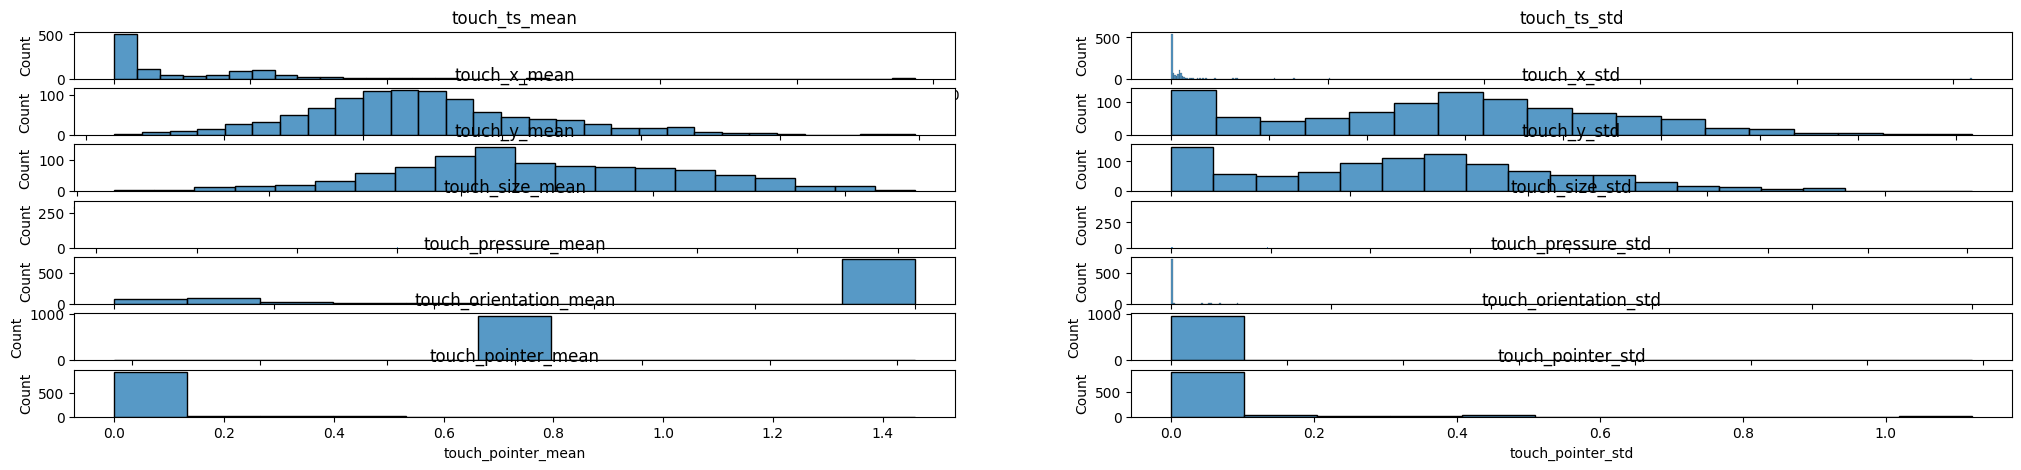

In [0]:

f, axes = plt.subplots(len(cols_woth_index), 2, figsize = (25, 5))

for (row, (col, _)) in enumerate(cols_woth_index):
    
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    ax_mean = axes[row][0]
    ax_atd = axes[row][1]
    sns.histplot(data=stats_sd.sample(1000), x=mean_col, ax = ax_mean)

    ax_mean.set_title(mean_col)
    
    sns.histplot(data=stats_sd.sample(1000), x=std_col, ax = ax_atd)
    ax_atd.set_title(std_col)

In [0]:
noise_cols = []

for (col, _) in cols_woth_index:    
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    noise_col = f"{col}_noise"
    
    df = df.withColumn(noise_col, F.col(mean_col)/F.col(std_col))
    noise_cols.append(noise_col)
noise_cols

['touch_ts_noise',
 'touch_x_noise',
 'touch_y_noise',
 'touch_size_noise',
 'touch_pressure_noise',
 'touch_orientation_noise',
 'touch_pointer_noise']

In [0]:

df = df.withColumn("noises", F.array(*[F.col(col) for col in noise_cols]))


In [0]:
array_mean_udf = udf(lambda values: np.mean([val for val in values if val is not None]), FloatType())

df = df.withColumn("noise_mean", array_mean_udf(F.col("noises")))

In [0]:
noise_mean_df = df.select(F.col("noise_mean")).toPandas()

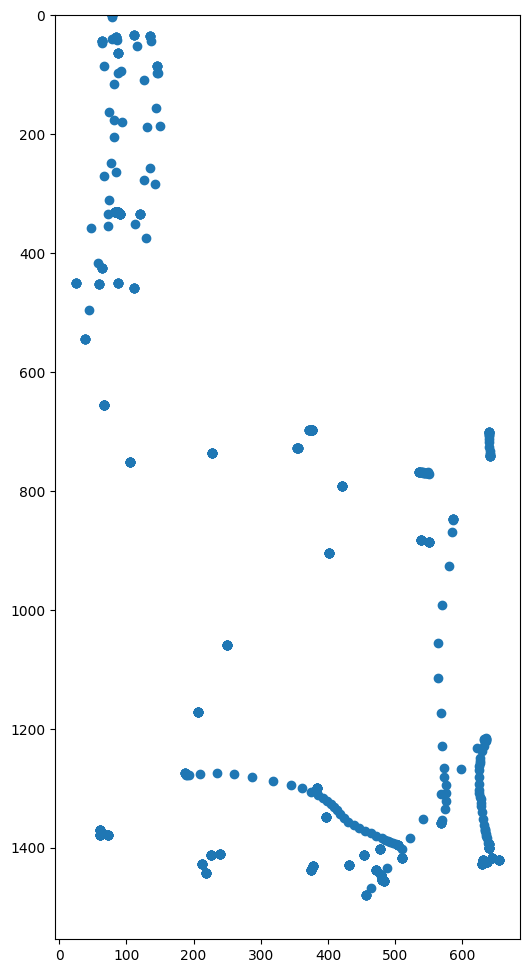

In [0]:
# simple visualization example
import matplotlib.pyplot as plt
import numpy as np



f = plt.figure(figsize=(6, 12))
seq_motion = np.array(seq_motion)
plt.scatter(seq_motion[:, MOTION_IDX_X], seq_motion[:, MOTION_IDX_Y])
plt.ylim(int(max(seq_motion[:, MOTION_IDX_Y])*1.05), 0)
plt.show()


##### **Bonus section**
- if you have access time, explore additional sensors like seq_acc (accelerometer values) and detail how you can use this data to improve your results.

In [0]:
# sensor event_property to index
class SensorIndices(IntEnum):
    TS = 0
    X = 1
    Y = 2
    Z = 3

SENSOR_IDX_TS = SensorIndices.TS.value
SENSOR_IDX_X = SensorIndices.X.value 
SENSOR_IDX_Y = SensorIndices.Y.value 
SENSOR_IDX_Z = SensorIndices.Z.value

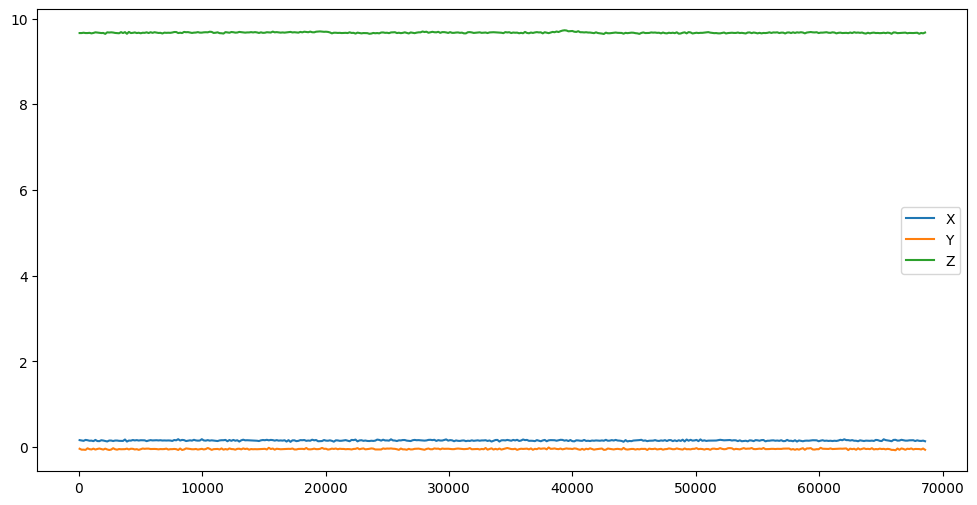

In [0]:
# simple example of plotting acc values over time
for row in df.limit(20).collect():
    seq_acc = row['seq_acc']
    if len(seq_acc) > 0:
        break
seq_acc = np.array(seq_acc)

f = plt.figure(figsize=(12, 6))
sensor_members = list(SensorIndices.__members__.keys())
plot_by = sensor_members[0]
plot_by_idx = SensorIndices[plot_by].value

for axis in sensor_members[1:]:
    plot_idx = SensorIndices[axis].value
    plt.plot(seq_acc[:, plot_by_idx], seq_acc[:, plot_idx], label=axis)

plt.legend()
plt.show()